In [21]:
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [22]:
file_dir = os.getcwd()
data_dir = os.path.join(file_dir, 'datasets')

In [23]:
# cds_csv_path = os.path.join(data_dir, 'cds.csv')
# cds_data = pd.read_csv(cds_csv_path, index_col='Date')

In [24]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


In [25]:
#load all used ticker names in a list.
with open('datasets/tickers.txt', 'r') as ticks:
    tickers = ticks.read().split('\n')[:-1]

In [26]:
#create a dictionary with ticker names and corresponding dataframe created by create_correct_dataframe()
ticks_DF_dict = {}
for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

In [27]:
ticks_DF_dict

{'A':            Ticker                   Company      PX1      PX2      PX3  \
 Date                                                                     
 2015-01-01      A  Agilent Technologies Inc  14.8500  25.0500  39.0550   
 2015-01-02      A  Agilent Technologies Inc  14.8550  25.1500  39.1600   
 2015-01-05      A  Agilent Technologies Inc  13.4550  24.9600  39.3100   
 2015-01-06      A  Agilent Technologies Inc  15.5350  24.8800  39.3000   
 2015-01-07      A  Agilent Technologies Inc  15.2150  25.5000  40.2700   
 ...           ...                       ...      ...      ...      ...   
 2021-09-06      A  Agilent Technologies Inc  23.3313  28.2419  33.1765   
 2021-09-07      A  Agilent Technologies Inc  23.4577  28.3343  33.2722   
 2021-09-08      A  Agilent Technologies Inc  25.5318  30.8480  36.2270   
 2021-09-09      A  Agilent Technologies Inc  23.7530  28.6880  33.6839   
 2021-09-10      A  Agilent Technologies Inc  25.0883  30.3039  35.5824   
 
                 P

In [28]:
def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50, squared=False):

    px_columns = [f'PX{i}' for i in range(1, 11)]

    # if ticker not in dataset:
    #     print(f"Ticker '{ticker}' not found in the dataset.")
    #     return

    tickerset = dataset[ticker]

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    # iterate over PX columns and plot ACF for each
    for i, col in enumerate(px_columns):
        if col not in tickerset.columns:
            print(f"Column '{col}' not found for ticker '{ticker}'.")
            continue

        price_col = tickerset[col].dropna()

        if not price_col.empty:
            if squared:
                plot_acf(price_col**2, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
            else:
                plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')

            axes[i].set_xlim(lagmin, lagmax)
            axes[i].set_xlabel("Lags")
            axes[i].set_ylabel("Autocorrelation")
        else:
            axes[i].set_title(f"Autocorr: {col} (No Data)")

    plt.tight_layout()
    plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
    plt.show()

In [119]:
def calculate_log_returns(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_dict = {}

    for ticker, df in dataset.items():
        returns_df = df.copy()
        for col in px_columns:
            # apply log returns transformation for each column
            returns_df[col] = 100*df[col].pct_change()
            # returns_df[col] = (np.log(df[col]) - np.log(df[col].shift(1))) * 100
        returns_dict[ticker] = returns_df.dropna()

    return returns_dict

In [30]:
def calculate_first_diffs(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    diffs_dict = {}

    for ticker, df in dataset.items():
        returns_df = df.copy()
        for col in px_columns:
            # apply log returns transformation for each column
            returns_df[col] = df[col] - df[col].shift(1)
        diffs_dict[ticker] = returns_df.dropna()

    return diffs_dict

In [120]:
cds_returns_dict = calculate_log_returns(ticks_DF_dict)

In [32]:
cds_diffs_dict = calculate_first_diffs(ticks_DF_dict)

In [87]:
cds_returns_dict['AAPL']['PX1'].mean()

0.002367651946801046

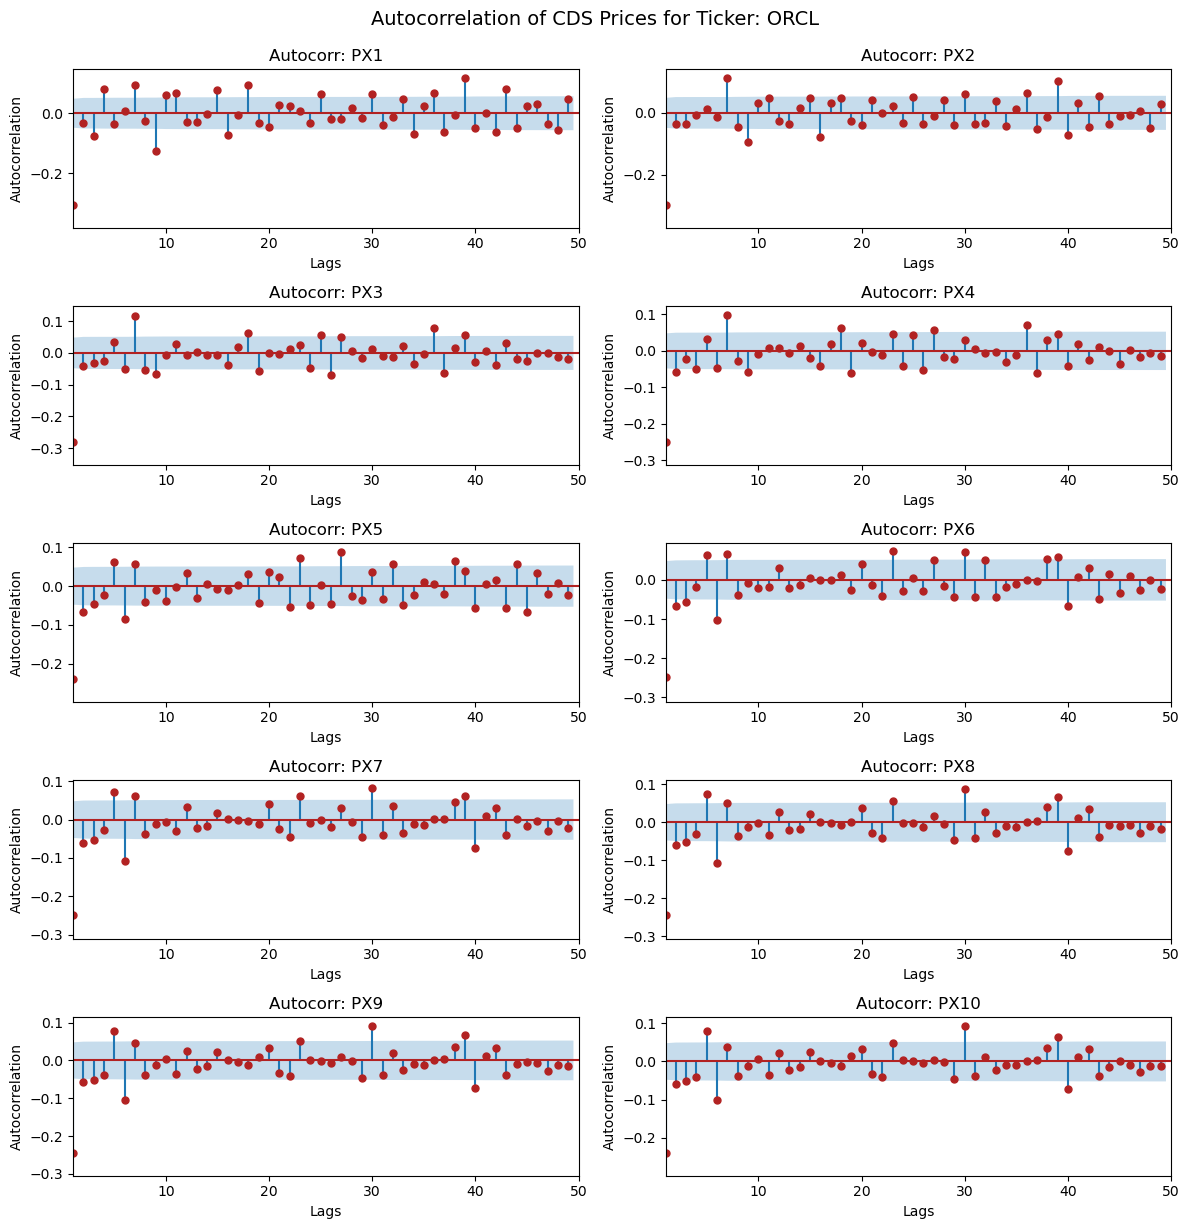

In [88]:
autocorrelation_plotter(cds_returns_dict, 'ORCL')

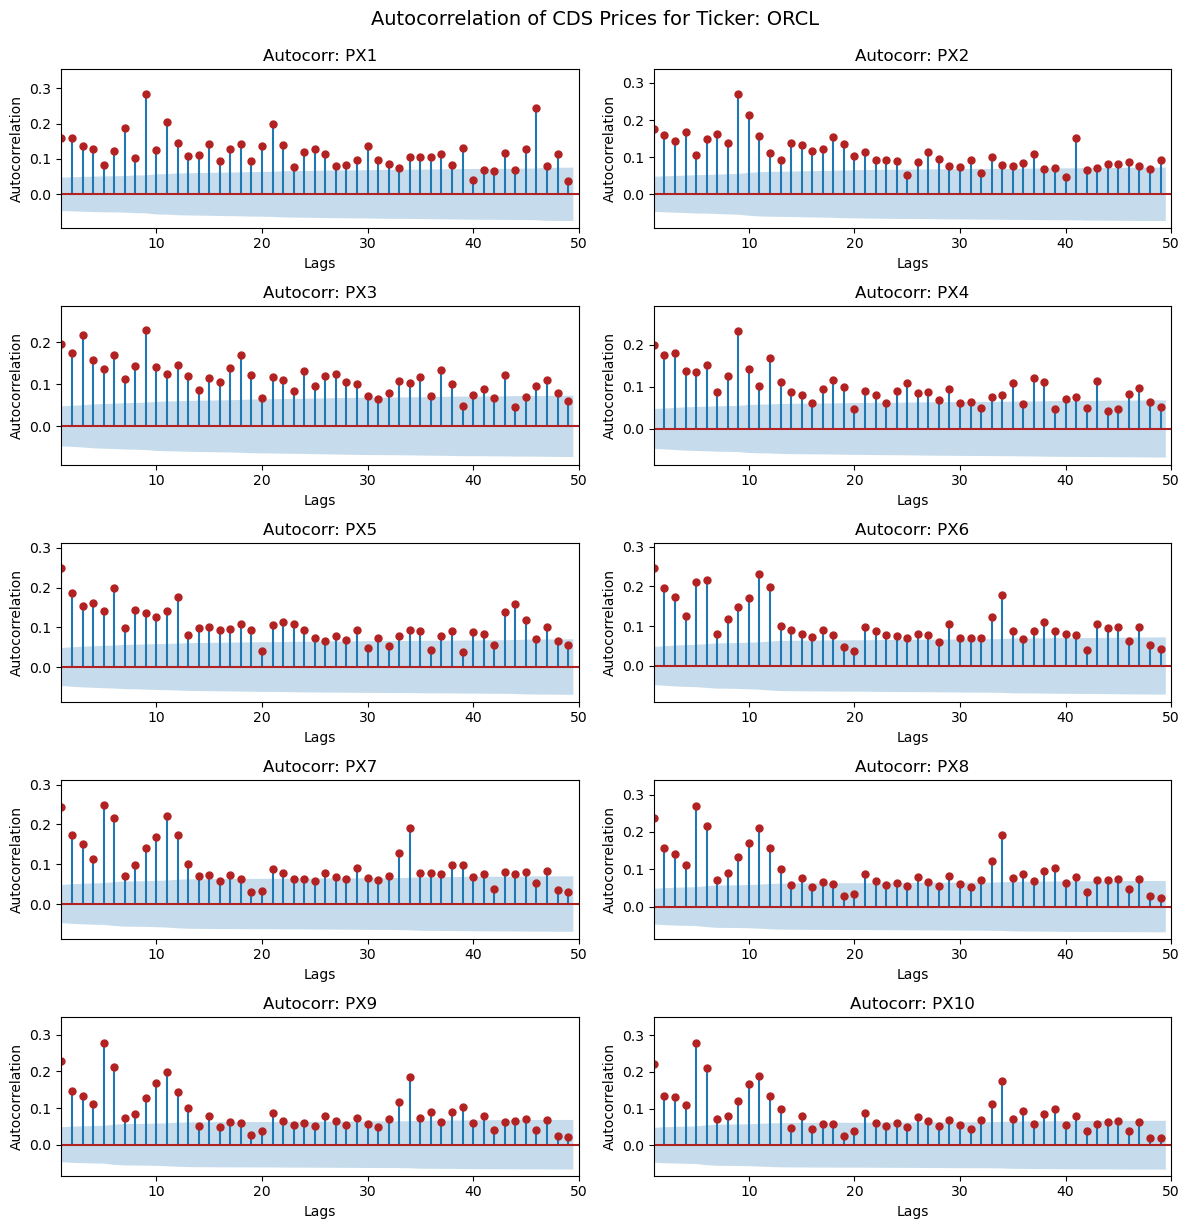

In [89]:
autocorrelation_plotter(cds_returns_dict, 'ORCL', squared=True)

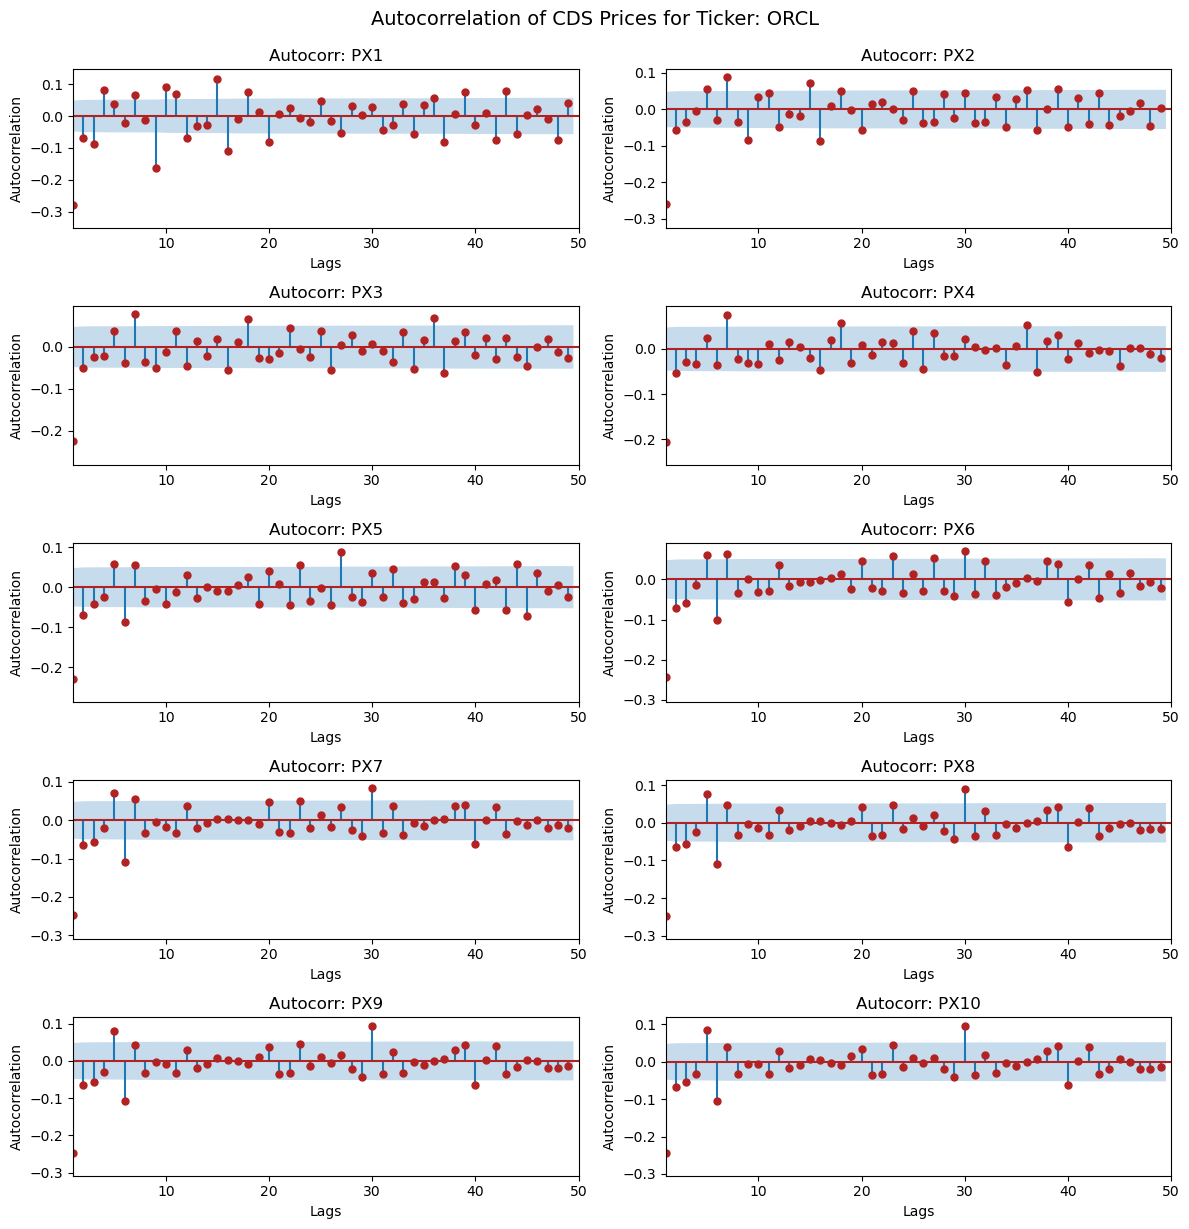

In [36]:
autocorrelation_plotter(cds_diffs_dict, 'ORCL')

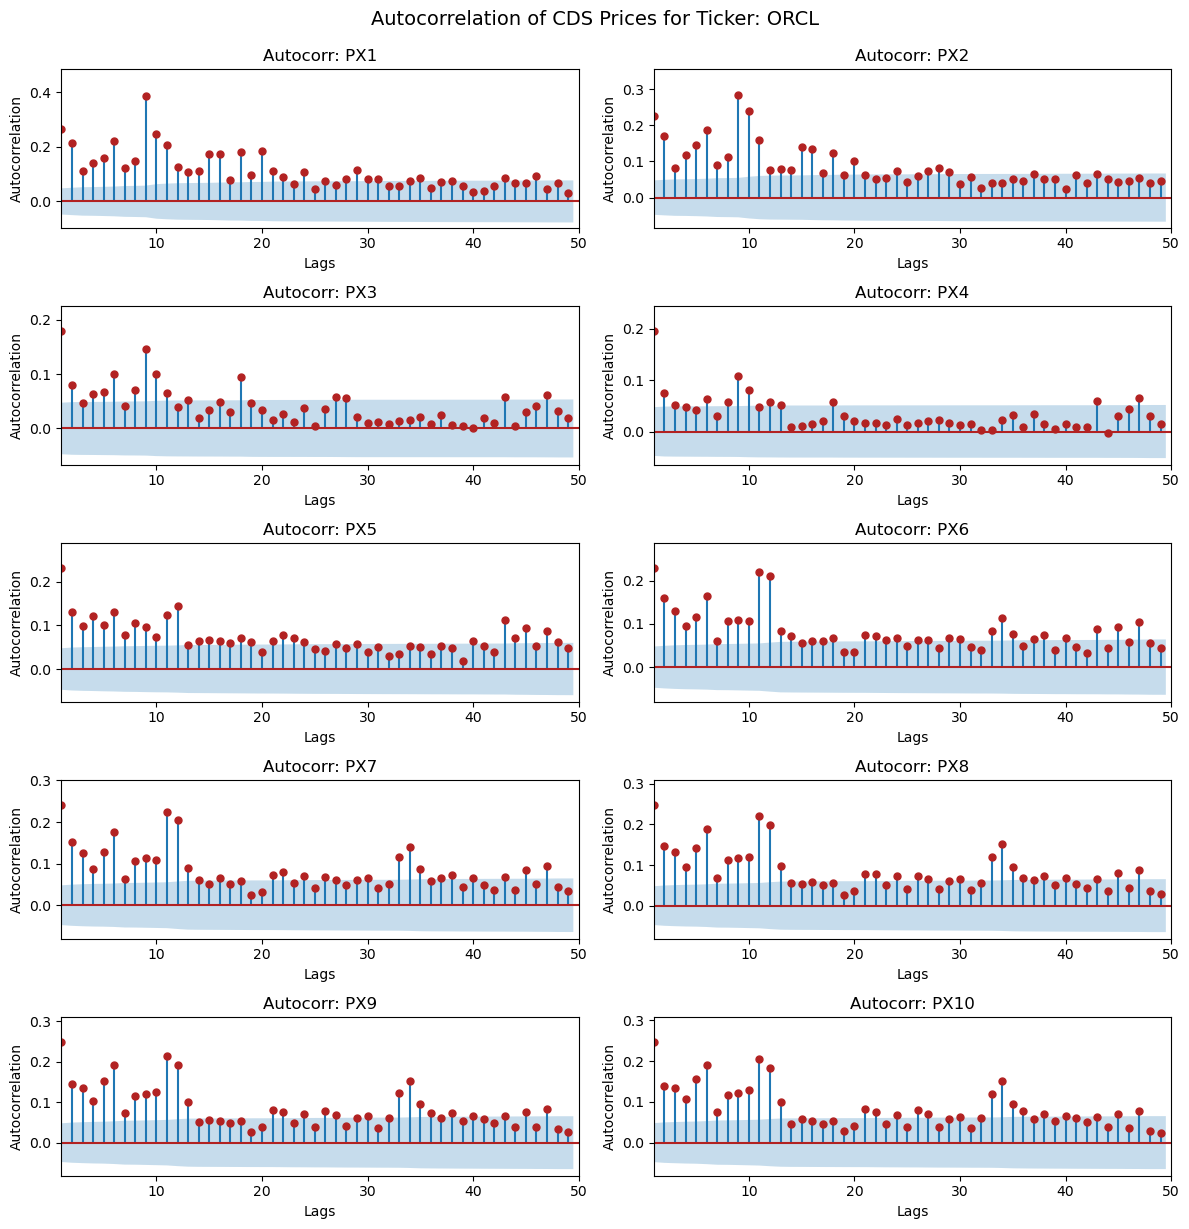

In [37]:
autocorrelation_plotter(cds_diffs_dict, 'ORCL', squared=True)

In [38]:
def split_train_test(cds_returns, split_date='2020-01-01'):
    train_set = {}
    test_set = {}

    for ticker, df in cds_returns.items():
        train_set[ticker] = df[df.index < split_date]
        test_set[ticker] = df[df.index >= split_date]
    
    return train_set, test_set

In [121]:
cds_returns_train, cds_returns_testfull = split_train_test(cds_returns_dict)
cds_returns_test, additional_test = split_train_test(cds_returns_testfull, split_date='2021-01-01')

In [40]:
cds_diffs_train, cds_diffs_testfull = split_train_test(cds_diffs_dict)
cds_diffs_test, additional_test_diff = split_train_test(cds_diffs_testfull, split_date='2021-01-01')

We can see that a GARCH model is appropriate here

Imported Parallel and delayed otherwise this code would take excessively long to run (days)

In [94]:
from joblib import Parallel, delayed

def fit_garch(data, p, q):
    model = arch_model(data, p=p, q=q, mean='Zero').fit(disp='off')
    return p, q, model.aic

In [42]:
def AIC_picker(dataset, max_p=3, max_q=3):
    px_columns = [f'PX{i}' for i in range(1, 11)]    
    results = {}

    # Iterate over tickers (keys in dataset dictionary)
    for ticker, df in dataset.items():
        results[ticker] = {}
        
        for col in px_columns:
            if col in df.columns:
                subset = df[col].dropna()
                if subset.empty:
                    results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
                    continue
                
                # Parallel fitting of GARCH models
                fit_results = Parallel(n_jobs=-1)(delayed(fit_garch)(subset, p, q) for p in range(1, max_p + 1) for q in range(1, max_q + 1))
                
                # Initialize with GARCH(1,1)
                best_aic = fit_garch(subset, p=1, q=1)[-1]
                best_order = (1, 1)

                for p, q, aic in fit_results:
                    if aic < best_aic:  # Minimize AIC
                        best_aic = aic
                        best_order = (p, q)

                results[ticker][col] = {'best_p': best_order[0], 'best_q': best_order[1], 'AIC': best_aic}
            else:
                results[ticker][col] = {'best_p': None, 'best_q': None, 'AIC': None}
    
    return results

In [43]:
aic_values_garch = AIC_picker(cds_diffs_train)

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

In [44]:
# aic_values_garch = AIC_picker(cds_returns_train)

In [45]:
aic_values_garch

{'A': {'PX1': {'best_p': 1, 'best_q': 3, 'AIC': 2756.9526752247075},
  'PX2': {'best_p': 2, 'best_q': 3, 'AIC': 3809.5592836848023},
  'PX3': {'best_p': 2, 'best_q': 3, 'AIC': 4948.103176114468},
  'PX4': {'best_p': 2, 'best_q': 3, 'AIC': 5902.784865737},
  'PX5': {'best_p': 2, 'best_q': 3, 'AIC': 6308.246539792665},
  'PX6': {'best_p': 1, 'best_q': 3, 'AIC': 6825.192507775503},
  'PX7': {'best_p': 1, 'best_q': 3, 'AIC': 7084.578991925897},
  'PX8': {'best_p': 2, 'best_q': 2, 'AIC': 7363.717334284206},
  'PX9': {'best_p': 1, 'best_q': 3, 'AIC': 7402.964520261543},
  'PX10': {'best_p': 1, 'best_q': 3, 'AIC': 7485.800728567812}},
 'AALLN': {'PX1': {'best_p': 2, 'best_q': 2, 'AIC': 6388.496391093824},
  'PX2': {'best_p': 3, 'best_q': 3, 'AIC': 7651.254569716193},
  'PX3': {'best_p': 1, 'best_q': 2, 'AIC': 8259.353686849463},
  'PX4': {'best_p': 3, 'best_q': 3, 'AIC': 8497.161789736645},
  'PX5': {'best_p': 3, 'best_q': 3, 'AIC': 8635.191374472874},
  'PX6': {'best_p': 1, 'best_q': 3, 'AIC

In [46]:
# # Parameters
# num_sims = 1000

# # Forecast 1-day returns for the test set using fitted GARCH parameters and actual observed test data
# def forecast_test_returns(train_set, test_set, aic_results, num_simulations=num_sims, column='PX1'):
#     forecasts = {}

#     for ticker in test_set.keys():

#         train_df = train_set[ticker]
#         test_df = test_set[ticker]

#         if column in train_df.columns and column in test_df.columns:
#             # retrieve best GARCH(p, q) orders
#             best_p = aic_results.get(ticker, {}).get(column, {}).get('best_p', 1)
#             best_q = aic_results.get(ticker, {}).get(column, {}).get('best_q', 1)

#             if not best_p or not best_q:
#                 print(f"Skipping {ticker} as no valid GARCH parameters found.")
#                 forecasts[ticker] = None
#                 continue

#             # fit GARCH on the train set
#             train_returns = train_df[column].dropna()
#             model = arch_model(train_returns, vol='Garch', p=best_p, q=best_q, mean='Zero')
#             model_fit = model.fit(disp='off')

#             forecasts[ticker] = []
#             rolling_volatility = np.sqrt(model_fit.forecast(horizon=1).variance.values[-1, -1])
#             previous_return = train_returns.iloc[-1]

#             # iteratively forecast 1-day ahead returns for the test set using observed data
#             for t in range(len(test_df)):
#                 omega = model_fit.params['omega']
#                 alpha = model_fit.params['alpha[1]']
#                 beta = model_fit.params['beta[1]']

#                 observed_return = test_df[column].iloc[t-1] if t > 0 else previous_return
#                 observed_squared = observed_return**2

#                 gjr_forecast = omega + alpha * observed_squared + beta * rolling_volatility**2
#                 rolling_volatility = np.sqrt(gjr_forecast)

#                 # Monte Carlo simulation for 1-day returns
#                 simulated_returns = rolling_volatility * np.random.randn(num_simulations)
#                 mean_forecast_return = simulated_returns.mean()
#                 forecasts[ticker].append(mean_forecast_return)

#                 previous_return = test_df[column].iloc[t]
#         else:
#             forecasts[ticker] = None

#     return forecasts

In [95]:
num_sims = 10**3
# Forecast 1-day returns for the test set using fitted GARCH parameters and actual observed test data
def forecast_test_returns(train_set, test_set, aic_results, num_simulations=num_sims, column='PX1'):
    forecasts = {}

    for ticker in test_set.keys():
        train_df = train_set[ticker]
        test_df = test_set[ticker]

        if column in train_df.columns and column in test_df.columns:
            # Retrieve best GARCH(p, q) orders
            best_p = aic_results.get(ticker, {}).get(column, {}).get('best_p', 1)
            best_q = aic_results.get(ticker, {}).get(column, {}).get('best_q', 1)

            if not best_p or not best_q:
                print(f"Skipping {ticker} as no valid GARCH parameters found.")
                forecasts[ticker] = None
                continue

            # Fit GARCH on the train set
            train_returns = train_df[column].dropna()
            model = arch_model(train_returns, vol='Garch', p=best_p, q=best_q, mean='Constant')
            model_fit = model.fit(disp='off')

            forecasts[ticker] = []
            rolling_volatility = np.sqrt(model_fit.forecast(horizon=1).variance.values[-1, -1])
            previous_return = train_returns.iloc[-1]

            # Iteratively forecast 1-day ahead returns for the test set
            for t in range(len(test_df)):
                omega = model_fit.params['omega']
                alpha = model_fit.params['alpha[1]']
                beta = model_fit.params['beta[1]']
                sigma_lag = model_fit.conditional_volatility.shift(1)
                mu = model_fit.params['const']

                observed_return = test_df[column].iloc[t-1] if t > 0 else previous_return
                observed_squared = observed_return**2

                # Forecast next volatility
                gjr_forecast = omega + alpha * observed_squared + beta * sigma_lag**2
                # rolling_volatility = np.sqrt(gjr_forecast)

                # Monte Carlo simulation for 1-day returns
                simulated_returns = mu + np.sqrt(gjr_forecast) * np.random.randn(num_simulations)
                mean_forecast_return = simulated_returns.mean()
                std_forecast_return = simulated_returns.std()

                # Calculate 95% confidence intervals
                lower_CI = mean_forecast_return - 1.96 * std_forecast_return
                upper_CI = mean_forecast_return + 1.96 * std_forecast_return

                # Append results as a tuple: (mean, lower CI, upper CI)
                forecasts[ticker].append((mean_forecast_return, lower_CI, upper_CI))

                previous_return = test_df[column].iloc[t]
        else:
            forecasts[ticker] = None

    return forecasts

In [105]:
import numpy as np
from arch import arch_model

num_sims = 10**3  # Number of Monte Carlo simulations

# Forecast 1-day returns for the test set using fitted GARCH parameters and actual observed test data
def forecast_test_returns(train_set, test_set, aic_results, num_simulations=num_sims, column='PX1'):
    forecasts = {}

    for ticker in test_set.keys():
        train_df = train_set[ticker]
        test_df = test_set[ticker]

        if column in train_df.columns and column in test_df.columns:
            # Retrieve best GARCH(p, q) orders
            best_p = aic_results.get(ticker, {}).get(column, {}).get('best_p', 1)
            best_q = aic_results.get(ticker, {}).get(column, {}).get('best_q', 1)

            if not best_p or not best_q:
                print(f"Skipping {ticker} as no valid GARCH parameters found.")
                forecasts[ticker] = None
                continue

            # Fit GARCH on the train set
            train_returns = train_df[column]#.dropna()
            model = arch_model(train_returns, vol='Garch', p=best_p, q=best_q, mean='Constant', rescale=True)
            model_fit = model.fit(disp='off')
            forecast = model_fit.forecast(horizon=1)

            # Initialize variables for rolling forecast
            forecasts[ticker] = []
            rolling_volatility = np.sqrt(model_fit.forecast(horizon=1).variance.values[-1, -1])
            previous_return = train_returns.iloc[-1]

            # Iteratively forecast 1-day ahead returns for the test set
            for t in range(len(test_df)):
                omega = model_fit.params['omega']
                alpha = model_fit.params['alpha[1]']
                beta = model_fit.params['beta[1]']
                mu = model_fit.params['mu']

                # Ensure sigma_lag is a scalar
                sigma_lag = rolling_volatility  # Use the latest rolling volatility

                # Get the observed return
                observed_return = test_df[column].iloc[t-1] if t > 0 else previous_return
                observed_squared = observed_return**2

                # Forecast next volatility
                gjr_forecast = omega + alpha * observed_squared + beta * sigma_lag**2
                rolling_volatility = np.sqrt(gjr_forecast)  # Update rolling volatility as scalar

                # Monte Carlo simulation for 1-day returns
                simulated_returns = mu + rolling_volatility * np.random.normal(size=num_simulations)
                mean_forecast_return = simulated_returns.mean()
                std_forecast_return = simulated_returns.std()

                # Calculate 95% confidence intervals
                lower_CI = mean_forecast_return - 1.96 * std_forecast_return
                upper_CI = mean_forecast_return + 1.96 * std_forecast_return

                # Append results as a tuple: (mean, lower CI, upper CI)
                forecasts[ticker].append((mean_forecast_return, lower_CI, upper_CI))

                # Update previous return
                previous_return = test_df[column].iloc[t]
        else:
            forecasts[ticker] = None

    return forecasts

In [122]:
def recursive_garch_forecast(train_set, test_set, aic_results, column='PX1'):
    
    forecast_results = {}

    for ticker in test_set.keys():
        train_df = train_set.get(ticker)
        test_df = test_set.get(ticker)

        # Check if column exists
        if train_df is None or test_df is None or column not in train_df.columns or column not in test_df.columns:
            forecast_results[ticker] = None
            continue

        # Retrieve best GARCH(p, q)
        best_p = aic_results.get(ticker, {}).get(column, {}).get('best_p', 1)
        best_q = aic_results.get(ticker, {}).get(column, {}).get('best_q', 1)

        # Fit the GARCH model once on the training data
        train_returns = train_df[column].dropna()
        am = arch_model(train_returns, vol='Garch', p=best_p, q=best_q, mean='Constant', dist='Normal')
        res = am.fit(disp='off')

        # Extract parameters
        params = res.params
        omega = params['omega']
        alpha = params['alpha[1]']
        beta = params['beta[1]']
        mu = params.get('mu', 0.0)

        # Last in-sample variance
        last_variance = (res.conditional_volatility.iloc[-1])**2
        # Last observed in-sample return
        last_return = train_returns.iloc[-1]
        last_residual = last_return - mu

        # Prepare a list for storing forecasts for each day
        forecasts_list = []

        # Recursively forecast each new day in the test set
        for date, new_ret in test_df[column].items():
            # Update the variance using the GARCH(1,1) recursion:
            # sigma_{t+1}^2 = omega + alpha*epsilon_t^2 + beta*sigma_t^2
            # Here epsilon_t = new_ret - mu
            current_residual = new_ret - mu
            next_variance = omega + alpha * (current_residual**2) + beta * last_variance

            mean_forecast = mu
            variance_forecast = next_variance
            std_forecast = np.sqrt(variance_forecast)

            forecasts_list.append({
                'date': date,
                'mean_forecast': mean_forecast,
                'variance_forecast': variance_forecast,
                'std_forecast': std_forecast
            })

            # Update the last_variance for the next iteration
            last_variance = next_variance

        # Convert list to DataFrame and set date as index
        if forecasts_list:
            df_forecasts = pd.DataFrame(forecasts_list).set_index('date')
        else:
            df_forecasts = pd.DataFrame(columns=['mean_forecast', 'variance_forecast', 'std_forecast'])

        forecast_results[ticker] = df_forecasts

    return forecast_results

In [123]:
forecasts_rets = recursive_garch_forecast(cds_returns_train, cds_returns_test, aic_values_garch)

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

 

In [126]:
forecasts_rets['AAPL']

,mean_forecast,variance_forecast,std_forecast
date,,,
2020-01-01,0.107068,7.908605,2.812224
2020-01-02,0.107068,7.908912,2.812279
2020-01-03,0.107068,7.909053,2.812304
2020-01-06,0.107068,7.918070,2.813907
2020-01-07,0.107068,7.933352,2.816621
...,...,...,...
2020-12-25,0.107068,7.986087,2.825967
2020-12-28,0.107068,70.967844,8.424241
2020-12-29,0.107068,80.904702,8.994704


In [129]:
lower_ci_apple, upper_ci_apple = forecasts_rets['AAPL']['mean_forecast'] - 1.96 * forecasts_rets['AAPL']['std_forecast'], forecasts_rets['AAPL']['mean_forecast'] + 1.96 * forecasts_rets['AAPL']['std_forecast']  
return_apple = (lower_ci_apple + upper_ci_apple) / 2

In [73]:
forecasts_diffs['AAPL'][1]

(7.896189538103577e-05, -0.036365143843368176, 0.03652306763413025)

In [80]:
def plot_forecast_returns(forecasts, ticker):
    
    # extract mean forecast and confidence intervals
    mean_forecasts = [item[0] for item in forecasts[ticker]]
    lower_CI = [item[1] for item in forecasts[ticker]]
    upper_CI = [item[2] for item in forecasts[ticker]]

    days = range(1, len(mean_forecasts) + 1)

    # mean forecasts and confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(days, mean_forecasts, label='Mean Forecast First-Difference', color='blue')
    # plt.fill_between(days, lower_CI, upper_CI, color='lightblue', alpha=0.4, label='95% Confidence Interval')

    # labels and title
    plt.title(f"1-Day Forecasted Returns for {ticker}")
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)

    # show plot
    plt.show()

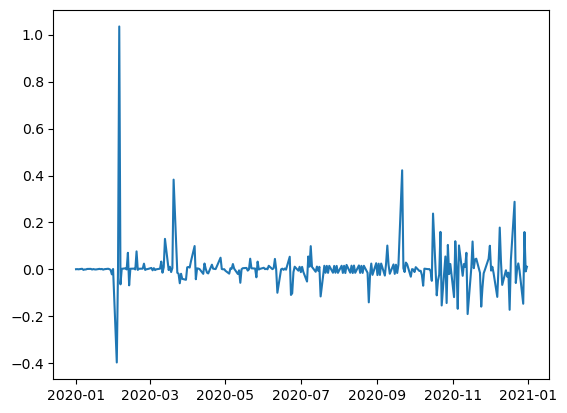

In [93]:
plt.plot(cds_returns_test['AAPL']['PX1'])

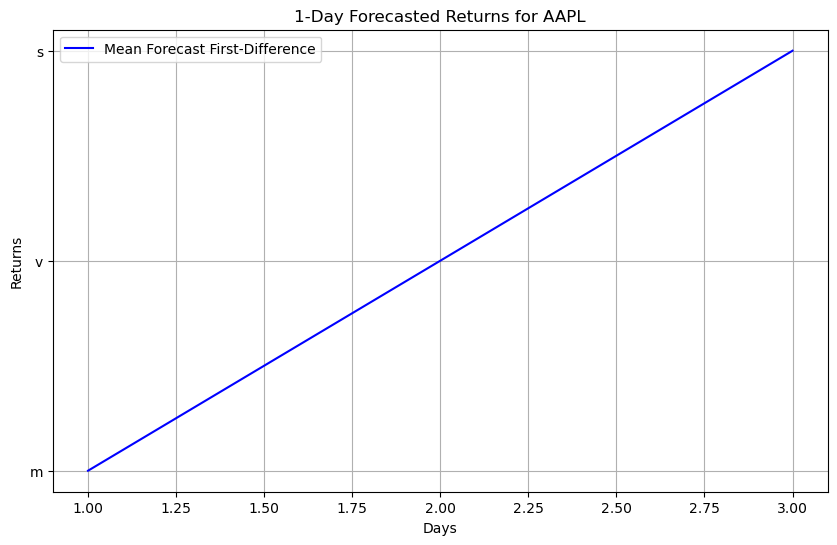

In [112]:
plot_forecast_returns(forecasts_rets, ticker='AAPL')

In [ ]:
def ten_day_price_forecast(dataset, model_results, K=10, MC=10000, dist='Normal', n_jobs=-1, mc_jobs=-1):

    def simulate_mc_batch(batch_size, shocks, omega, alpha, beta, one_day_variance, K):

        cond_variance = np.zeros((K, batch_size))
        cond_variance[0, :] = one_day_variance

        for k in range(1, K):
            cond_variance[k, :] = omega + alpha * (shocks[k-1, :] ** 2) + beta * cond_variance[k-1, :]

        sim_returns = np.sqrt(cond_variance) * shocks
        sim_cumulative_returns = np.cumsum(sim_returns, axis=0)
        return sim_cumulative_returns

    def simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K):

        # fit GARCH
        model = arch_model(subset, vol='Garch', p=p_opt, q=q_opt, mean='Zero', rescale=True)
        result = model.fit(disp="off")
        
        # 1-day ahead variance forecast
        forecast = result.forecast(horizon=1)
        one_day_ahead_variance = forecast.variance.iloc[-1, 0]

        # GARCH params
        omega = result.params['omega']
        alpha = result.params['alpha[1]']
        beta = result.params['beta[1]']

        # Monte Carlo shocks
        batch_size = MC // 10  # Split into 10 batches
        total_batches = 10

        if dist == 'Normal':
            shocks = [np.random.randn(K, batch_size) for _ in range(total_batches)]
        else:
            d1 = result.distribution.df
            shocks = [np.sqrt((d1 - 2) / d1) * stats.t.rvs(d1, size=(K, batch_size)) for _ in range(total_batches)]

        # parallelize Monte Carlo batches
        mc_results = Parallel(n_jobs=mc_jobs)(delayed(simulate_mc_batch)(batch_size, shocks[i], omega, alpha, beta, one_day_ahead_variance, K) for i in range(total_batches))

        return np.hstack(mc_results)

    # parallel Execution
    px_columns = [f'PX{i}' for i in range(1, 11)]
    tickers = dataset['Ticker'].unique()
    forecast_results = {}

    for col in px_columns:
        forecast_results[col] = {}

        def process_ticker(ticker):
            subset = dataset[dataset['Ticker'] == ticker][col].dropna()

            p_opt = model_results[col][ticker]['best_p']
            q_opt = model_results[col][ticker]['best_q']

            # sim cumulative returns
            sim_cumulative_returns = simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K)
            return ticker, sim_cumulative_returns

        # parallel processing for all tickers
        results = Parallel(n_jobs=n_jobs)(delayed(process_ticker)(ticker) for ticker in tickers)

        for ticker, simulation_results in results:
            if simulation_results is not None:
                forecast_results[col][ticker] = simulation_results

    return forecast_results

In [ ]:
def forecast_all_paths(cds_returns, returns_forecast):

    px_columns = [f'PX{i}' for i in range(1, 11)]
    tickers = cds_returns['Ticker'].unique()

    all_paths_forecast = {}

    for col in px_columns:
        all_paths_forecast[col] = {}

        for ticker in tickers:
            last_price = cds_returns[cds_returns['Ticker'] == ticker][col].dropna().iloc[-1]
            sim_cumulative_returns = returns_forecast[col][ticker]  # shape: (K, MC)

            # convert cum. returns to prices - * 10**4 because prices in bps 
            price_paths = last_price * np.exp(sim_cumulative_returns / 100)

            all_paths_forecast[col][ticker] = price_paths

    return all_paths_forecast